In [1]:
import os
import os.path as osp
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
import numpy as np                # Numpy for array manipulation for ease of access
import torch                      # Pytorch for array manipulation on the GPU and nice deep learning functions
import torch.nn as nn
import torch.nn.functional as functional
import torch.utils.data as data
import torch.optim as optim
import torchvision
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import SubsetRandomSampler
from torchvision import transforms as tfs
import cv2
# Image import and display libraries                       # OpenCV for image processing
import matplotlib.pyplot as plt   # Plotting functions
from PIL import Image
%matplotlib inline

# Image processing libraries for image feature extractor
from scipy.stats import kurtosis, skew
from scipy.ndimage import generic_filter
from skimage.filters import laplace, gabor
from skimage.filters.rank import entropy
from skimage.morphology import disk
from sklearn.preprocessing import scale

# A few more tools
from sklearn import svm           # SVM classifier library
import os                         # Navigate through directories
import csv                        # Read in a CSV file
import time                       # Timing function
import pickle                     # Saving and loading variables

In [2]:
TRAIN_BATCH_SIZE = 10
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
use_gpu = False
if torch.cuda.is_available():
    use_gpu = True
    print("using cuda")


using cuda


In [3]:
class TeratomaDataset(data.Dataset):
    def __init__(self, root_folder, image_transforms=None, gt_transforms=None):
        '''
            reference dataset loading for TeratomaDataset
            root_folder: the root_folder of the TeratomaDataset 
            set_indices: is the indices for sets to be used
            subset_indices: is the indices for the subsets to be used
            split: 'train', 'val' or 'test'
            domain: the image domains to be loaded.
            image_transforms: any transforms to perform, can add augmentations here.
            gt_transforms: list of bool. Indicates whether image_transforms should also be appleid to gt.
        '''

        self.input_folder = osp.join(root_folder, 'input')
        self.seg_folders = {
            'GI': osp.join(root_folder, 'segmentation', 'GI'),
            'Cartilage': osp.join(root_folder, 'segmentation', 'Cartilage'),
            'RPE': osp.join(root_folder, 'segmentation', 'RPE'),
            'Neural': osp.join(root_folder, 'segmentation', 'Neural'),
        }

        self.image_paths = sorted([
            osp.join(self.input_folder, fname)
            for fname in os.listdir(self.input_folder)
            if fname.endswith('.png')
        ])

        self.image_transforms = image_transforms
        self.gt_transforms = gt_transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_name = osp.basename(image_path)

        # Load input image, normalize
        image = Image.open(image_path).convert('RGB')
        # image = np.array(image).astype(np.float32) / 255.0

        # Load 4 segmentation layers

        gt_layers = []
        for key in ['GI', 'Cartilage', 'RPE', 'Neural']:
            seg_path = osp.join(self.seg_folders[key], image_name)
            seg = Image.open(seg_path).convert('L')
            seg = (np.array(seg) > 0).astype(np.uint8)  # binary mask
            gt_layers.append(seg)

        gt = np.stack(gt_layers, axis=0)  # shape: (4, H, W)
        target = torch.from_numpy(gt).float()  # shape (H, W)

        # Transforms
        if self.image_transforms:
            image = self.image_transforms(image)
        else:
            image = tfs.ToTensor()(image)

        # if self.gt_transforms:
        #     gt = self.gt_transforms(gt)
        # else:
        #     gt = torch.from_numpy(gt).float()  # (4, H, W)


        return image, target


# Model Architecture

In [4]:

def add_conv_stage(dim_in, dim_out, kernel_size=3, stride=1, padding=1, bias=True, useBN=False):
  if useBN:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.BatchNorm2d(dim_out),
      nn.LeakyReLU(0.1)
    )
  else:
    return nn.Sequential(
      nn.Conv2d(dim_in, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU(),
      nn.Conv2d(dim_out, dim_out, kernel_size=kernel_size, stride=stride, padding=padding, bias=bias),
      nn.ReLU()
    )

def upsample(ch_coarse, ch_fine):
  return nn.Sequential(
    nn.ConvTranspose2d(ch_coarse, ch_fine, 4, 2, 1, bias=False),
    nn.ReLU()
  )

class unet(nn.Module):
  def __init__(self, useBN=False):    #Change useBN to True
    super(unet, self).__init__()
    # Downgrade stages
    self.conv1   = add_conv_stage(3, 32, useBN=useBN)
    self.conv2   = add_conv_stage(32, 64, useBN=useBN)
    self.conv3   = add_conv_stage(64, 128, useBN=useBN)
    self.conv4   = add_conv_stage(128, 256, useBN=useBN)
    self.conv5   = add_conv_stage(256, 512, useBN=useBN)
    # Upgrade stages
    self.conv4m = add_conv_stage(512, 256, useBN=useBN)
    self.conv3m = add_conv_stage(256, 128, useBN=useBN)
    self.conv2m = add_conv_stage(128,  64, useBN=useBN)
    self.conv1m = add_conv_stage( 64,  32, useBN=useBN)
    # Maxpool
    self.max_pool = nn.MaxPool2d(2)
    # Upsample layers
    self.upsample54 = upsample(512, 256)
    self.upsample43 = upsample(256, 128)
    self.upsample32 = upsample(128,  64)
    self.upsample21 = upsample(64 ,  32)

    ## TODO last layer & activations
    self.output_conv = nn.Conv2d(32, 4, 1)
    # self.activation = nn.Softmax(dim=1)


  def forward(self, x):
    #TODO implement forward function
    # Downgrade
    x1 = self.conv1(x)                    #1 -> 32 channels
    x2 = self.conv2(self.max_pool(x1))    #32 -> 64 channels
    x3 = self.conv3(self.max_pool(x2))    #64 -> 128 channels
    x4 = self.conv4(self.max_pool(x3))    #128 -> 256 channels
    x5 = self.conv5(self.max_pool(x4))    #256 -> 512 channels

    # Upgrade
    x4m = self.upsample54(x5)             #512 -> 256 channels
    x4m = torch.cat((x4, x4m), dim=1)
    x4m = self.conv4m(x4m)

    x3m = self.upsample43(x4m)            #256 -> 128 channels
    x3m = torch.cat((x3, x3m), dim=1)
    x3m = self.conv3m(x3m)

    x2m = self.upsample32(x3m)            #128 -> 64 channels
    x2m = torch.cat((x2, x2m), dim=1)
    x2m = self.conv2m(x2m)

    x1m = self.upsample21(x2m)            #64 -> 32 channels
    x1m = torch.cat((x1, x1m), dim=1)
    x1m = self.conv1m(x1m)

    # Output
    output = self.output_conv(x1m)      #32 -> 4 channels
    # output = self.activation(output)
    return output

## Training Loop

In [5]:
def trainning(model, trainning_dataloader, validation_dataloader, num_epochs, criterion, optimizer, filename):
    if use_gpu:
      model.cuda()
    lr_changed = False
    trainning_losses = []
    validation_losses = []
    total_training_loss = 0
    total_val_loss = 0
    total_training_iteration = 0
    total_val_iteration = 0
    for epoch in range(num_epochs):
        i = 0
        model.train()
        for data in trainning_dataloader:
          img,y = data
          if use_gpu:
            img = img.cuda()
            y = y.cuda()
          out = model(img)
          optimizer.zero_grad()
          loss = criterion(out, y)
          total_training_loss += loss.item()
          # loss.backward()
          optimizer.step()
          i = i+1
          total_training_iteration += 1
          if total_training_iteration % 100 == 99:
            trainning_losses.append(total_training_loss / total_training_iteration)
        if epoch % 5 == 4:
            print("learning_rate decayed")
            for param_group in optimizer.param_groups:
              param_group['lr'] *= 0.1
        model.eval()
        with torch.no_grad():
          for data in validation_dataloader:
            img,y = data
            if use_gpu:
              img = img.cuda()
              y = y.cuda()
            out = model(img)
            optimizer.zero_grad()
            loss = criterion(out, y)
            total_val_loss += loss.item()
            total_val_iteration += 1
            if total_val_iteration % 100 == 99:
              validation_losses.append(total_val_loss / total_val_iteration)
        print("epoch:",epoch,"training_loss:",total_training_loss / total_training_iteration, "validation_loss:",total_val_loss / total_val_iteration)
        torch.save(model.state_dict(), filename)
        
    # Plotting training and validation losses in subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # Plot training loss
    ax1.plot(trainning_losses, label='Training Loss')
    ax1.set_title("Training Loss")
    ax1.set_xlabel("Iterations (x100)")
    ax1.set_ylabel("Loss")
    
    # Plot validation loss
    ax2.plot(validation_losses, label='Validation Loss')
    ax2.set_title("Validation Loss")
    ax2.set_xlabel("Iterations (x100)")
    ax2.set_ylabel("Loss")
    
    plt.tight_layout()
    plt.show()

### Define transforms and dataset

In [6]:
root_folder = r"C:\Users\willllllli\Documents\Dr. Z lab\Teratoma_Segmentation\DATA\20240606165451_Dec 2023 E32C6 L4i undiff"

mean = [0.68358143, 0.5290253,  0.61094054] 
std = [0.11946411, 0.2183087,  0.09772461]
size = (512, 512)

image_transforms = tfs.Compose([
    tfs.Resize(size, interpolation=tfs.InterpolationMode.BILINEAR),
    tfs.ToTensor(),
    tfs.Normalize(mean=mean, std=std),
])

gt_transforms = tfs.Compose([
    tfs.Resize(size, interpolation=tfs.InterpolationMode.NEAREST),
    tfs.ToTensor(),
])


In [7]:
full_ds = TeratomaDataset(
    root_folder=root_folder,
    image_transforms=image_transforms,
    gt_transforms=gt_transforms
)

N = len(full_ds)
train_N = int(0.8 * N)
val_N   = int(0.1 * N)
test_N  = N - train_N - val_N  # ensure sums to N

generator = torch.Generator().manual_seed(42)
train_ds, val_ds, test_ds = random_split(full_ds, [train_N, val_N, test_N], generator=generator)

batch_size = 8
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)


In [8]:
def show_demo(model, test_dataset_loader, num=10):
    model.eval()
    count = 0
    for demo in test_dataset_loader:
        demo_input, demo_target = demo
        if use_gpu:
           demo_input = demo_input.cuda()
        demo_output = model(demo_input)
        for i in range(demo_input.shape[0]):
            plt.subplot(1, 3, 1)
            plt.imshow(demo_input[i].permute(1,2,0).detach().cpu().numpy())
            plt.axis("off")
            plt.subplot(1, 3, 2)
            plt.imshow(demo_output[i].detach().cpu().numpy().squeeze()*255)
            plt.axis("off")
            plt.subplot(1, 3, 3)
            plt.imshow(demo_target[i].detach().numpy().squeeze())
            plt.axis("off")
            plt.show()
        if count >= num:
          break
        count += 1

epoch: 0 training_loss: 0.6705068367564545 validation_loss: 0.6668024045579574
epoch: 1 training_loss: 0.6705775057072976 validation_loss: 0.6666881196639117
epoch: 2 training_loss: 0.6705670409190758 validation_loss: 0.668061696431216
epoch: 3 training_loss: 0.6705503232195474 validation_loss: 0.6673692881184465
learning_rate decayed
epoch: 4 training_loss: 0.6705408815557629 validation_loss: 0.6674047424512751
epoch: 5 training_loss: 0.6705689420265779 validation_loss: 0.6671266032784593
epoch: 6 training_loss: 0.6705394549630642 validation_loss: 0.6670680003506797
epoch: 7 training_loss: 0.6705253687323691 validation_loss: 0.6668671547051739
epoch: 8 training_loss: 0.6705291196857784 validation_loss: 0.6672835667538487
learning_rate decayed
epoch: 9 training_loss: 0.6705194744257236 validation_loss: 0.6672875740948845


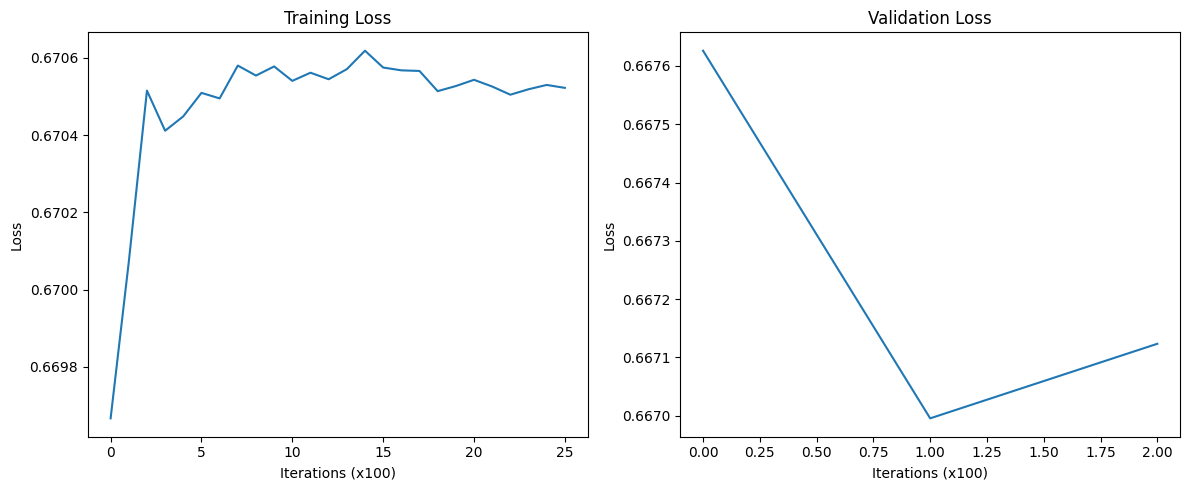

In [9]:
segmentation_model = unet(useBN=True)
criterion = nn.BCEWithLogitsLoss()
segmentation_optimizer = torch.optim.Adam(segmentation_model.parameters(), lr=LEARNING_RATE, weight_decay=1e-4)
trainning(segmentation_model, train_loader, val_loader,  NUM_EPOCHS, criterion, segmentation_optimizer, "final_vanilla_model.pth")

C:\Users\willllllli\AppData\Local\Temp\ipykernel_34800\1723197215.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  segmentation_model.load_state_dict(torch.load("final_va

TypeError: Invalid shape (4, 512, 512) for image data

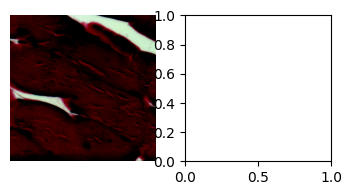

In [10]:
segmentation_model.load_state_dict(torch.load("final_vanilla_model.pth"))
# print(DICE(segmentation_model, segmentation_test_dataloader))
show_demo(segmentation_model, test_loader)